In [21]:
import numpy as np
from matplotlib import pyplot as plt

from snn.layers import SCTNLayer
from snn.resonator import lp_by_lf
from snn.spiking_network import SpikingNetwork
from snn.spiking_neuron import create_SCTN, IDENTITY, INJECT


def neuron_output(neuron, duration, signal_freq, shift_degrees=0):
    y_events = neuron.out_spikes()
    samples_per_cycle =  clk_freq / signal_freq
    samples_per_degree = samples_per_cycle/360
    shift_samples = int(shift_degrees*samples_per_degree)
    y_events = y_events[
        (y_events > (duration - (8/signal_freq)) * clk_freq + shift_samples) &
        (y_events < (duration - (2/signal_freq)) * clk_freq + shift_samples)
    ]
    if len(y_events) == 0:
        raise ValueError("No spikes were emit.")
    y_events -= y_events[0]
    return y_events

def events_to_spikes(events, run_window=0):
    y_spikes = np.zeros(events[-1] + 1)
    y_spikes[events] = 1
    if run_window == 0:
        return y_spikes

    y_spikes_rollsum = np.convolve(y_spikes, np.ones(run_window, dtype=int), 'valid')
    return y_spikes_rollsum

clk_freq = 1536000
duration = .4
freq0 = 104

x = np.linspace(0, duration, int(duration * clk_freq))
t = x * 2 * np.pi * freq0
sine_wave = np.sin(t)

In [22]:
resonator = SpikingNetwork(clk_freq)
resonator.add_amplitude(1000)

# Encode to pdm
neuron = create_SCTN()
neuron.activation_function = IDENTITY
resonator.add_layer(SCTNLayer([neuron]))
resonator.log_out_spikes(-1)

resonator.input_full_data(sine_wave)
resonator_input = neuron_output(resonator.neurons[0], duration, freq0, shift_degrees=0)
gt1 = neuron_output(resonator.neurons[0], duration, freq0, shift_degrees=-45)
gt2 = neuron_output(resonator.neurons[0], duration, freq0, shift_degrees=-90)
gt3 = neuron_output(resonator.neurons[0], duration, freq0, shift_degrees=-135)
gt4 = neuron_output(resonator.neurons[0], duration, freq0, shift_degrees=-180)

In [23]:
def injected_resonator(
        lf,
        thetas,
        weights,
        ground_truths,
        A_LTP,
        A_LTD,
        time_to_learn,
        max_weight,
        min_weight,
):
    LF = lf
    LP = lp_by_lf(LF, freq0, clk_freq)
    network = SpikingNetwork(clk_freq)
    tau = network.clk_freq * time_to_learn / 2

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weights[0], -weights[1]], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = thetas[0]
    neuron.activation_function = INJECT
    neuron.injected_output_spikes = ground_truths[0]
    neuron.membrane_should_reset = False
    neuron.set_stdp(A_LTP, A_LTD, tau, clk_freq, max_weight, min_weight)
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weights[2+i]], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = thetas[1+i]
        neuron.activation_function = INJECT
        neuron.injected_output_spikes = ground_truths[1 + i]
        neuron.membrane_should_reset = False
        neuron.set_stdp(A_LTP, A_LTD, tau, clk_freq, max_weight, min_weight)
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(3, 0)
    return network

def simple_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
):
    LF = lf
    LP = lp_by_lf(LF, freq0, clk_freq)
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weights[0], -weights[1]], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = thetas[0]
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weights[2+i]], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = thetas[1+i]
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

In [26]:
resonator = injected_resonator(
    lf=5,
    thetas=[-1, -5, -5, -5],
    weights=np.random.random(5)*15,#[5, 5, 5, 5, 5],
    ground_truths=[gt1, gt2, gt3, gt4],
    A_LTP=5e-4,
    A_LTD=-5e-4,
    time_to_learn=2e-6,
    max_weight=15,
    min_weight=-15,
)

In [27]:
%matplotlib notebook
input_spikes_train = np.array([events_to_spikes(resonator_input), events_to_spikes(gt4)]).T

def flat_weights(resonator):
    ws = []
    for neuron in resonator.neurons:
        for w in neuron.synapses_weights:
            ws.append(abs(float(f'{w:.3f}')))
    return np.array(ws)

def flat_thetas(resonator):
    return [float(f'{neuron.theta:.3f}') for neuron in resonator.neurons]

epochs = 50

weights = np.zeros((epochs+1, 5))
weights[0, :] = flat_weights(resonator)

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_xlim(0, epochs+1)
lines = [ax.plot([w], label=f'weight {i}')[0] for i, w in enumerate(weights[0])]
for i in range(1, epochs+1):
    resonator.input_full_data_spikes(input_spikes_train)
    resonator.forget_logs()
    weights[i, :] = flat_weights(resonator)
    for j, line in enumerate(lines):
        line.set_xdata(np.arange(i))
        line.set_ydata(weights[:i, j])

    ax.set_ylim(-15, 15)
    ax.legend()
    fig.canvas.draw()
    fig.canvas.flush_events()

<IPython.core.display.Javascript object>

In [15]:
flat_weights(resonator)

array([14.963, 14.983, 13.887, 11.898,  6.368])

In [18]:
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=5,
    thetas=flat_thetas(resonator),
    weights=flat_weights(resonator),
)

for i in range(len(res_resonator.neurons)):
    res_resonator.log_out_spikes(i)

# res_resonator.input_full_data(np.zeros_like(sine_wave))
res_resonator.input_full_data(sine_wave)
output = [events_to_spikes(neuron_output(neuron, duration, freq0), run_window=500) for neuron in res_resonator.neurons]
# output = [neuron_output(neuron, duration, freq0) for neruon in res_resonator.neurons]

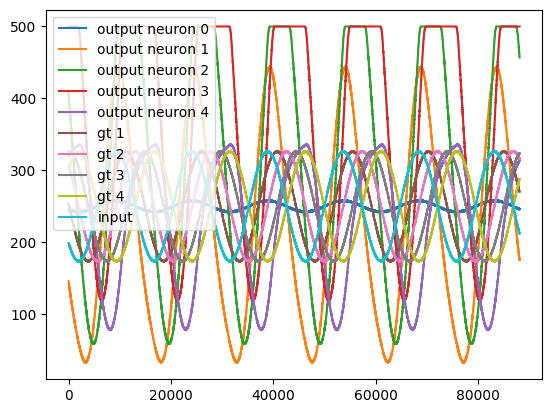

In [20]:
%matplotlib inline

for i, o in enumerate(output):
    plt.plot(o, label=f'output neuron {i}')

for i, gt in enumerate([gt1, gt2, gt3, gt4]):
    plt.plot(events_to_spikes(gt, run_window=500), label=f'gt {i+1}')
plt.plot(events_to_spikes(resonator_input, run_window=500), label=f'input')

plt.legend()